In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json, os
import joblib
from itertools import product
from sklearn.base import clone
import matplotlib.ticker as mticker


from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
def getAUC(model, xTest, yTest):
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(xTest)[:, 1]
    else:
        y_score = model.decision_function(xTest)
    
    return y_score, roc_auc_score(yTest, y_score)

# EXTRAINDO DADOS

In [3]:
df = pd.read_csv('files/Model.csv')
df

,tenure,InternetService_Fiber optic,Contract_Two year,PaymentMethod_Electronic check,InternetService_No,TotalCharges,MonthlyCharges,PaperlessBilling,Contract_One year,OnlineSecurity,TechSupport,Dependents,SeniorCitizen,Partner,Churn
0,1,False,False,True,False,29.85,29.85,True,False,False,False,False,0,True,False
1,34,False,False,False,False,1889.50,56.95,False,True,True,False,False,0,False,False
2,2,False,False,False,False,108.15,53.85,True,False,True,False,False,0,False,True
3,45,False,False,False,False,1840.75,42.30,False,True,True,True,False,0,False,False
4,2,True,False,True,False,151.65,70.70,True,False,False,False,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,False,False,False,False,1990.50,84.80,True,True,True,True,True,0,True,False
7039,72,True,False,False,False,7362.90,103.20,True,True,False,False,True,0,True,False
7040,11,False,False,True,False,346.45,29.60,True,False,True,False,True,0,True,False
7041,4,True,False,False,False,306.60,74.40,True,False,False,False,False,1,True,True


In [4]:
xData = df.drop(columns=['Churn'])
yData = df['Churn'].values

N_STATES = len(xData.columns)
print('n states: ', N_STATES)

xData

n states:  14


,tenure,InternetService_Fiber optic,Contract_Two year,PaymentMethod_Electronic check,InternetService_No,TotalCharges,MonthlyCharges,PaperlessBilling,Contract_One year,OnlineSecurity,TechSupport,Dependents,SeniorCitizen,Partner
0,1,False,False,True,False,29.85,29.85,True,False,False,False,False,0,True
1,34,False,False,False,False,1889.50,56.95,False,True,True,False,False,0,False
2,2,False,False,False,False,108.15,53.85,True,False,True,False,False,0,False
3,45,False,False,False,False,1840.75,42.30,False,True,True,True,False,0,False
4,2,True,False,True,False,151.65,70.70,True,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,False,False,False,False,1990.50,84.80,True,True,True,True,True,0,True
7039,72,True,False,False,False,7362.90,103.20,True,True,False,False,True,0,True
7040,11,False,False,True,False,346.45,29.60,True,False,True,False,True,0,True
7041,4,True,False,False,False,306.60,74.40,True,False,False,False,False,1,True


# SELECIONANDO MODELO

In [5]:
class ModelSelector:
    options = {
        'logistic_regression': {
            'model': LogisticRegression(),
            'params': {
                'C': [0.1, 1, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga'],
                'max_iter': [100, 200, 500, 800, 1000, 1500, 2000, 3000, 4000]
            }
        },
        'knn': {
            'model': KNeighborsClassifier(n_neighbors=2), # Base solicitado
            'params': {
                'n_neighbors': [2, 3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },
        'svm': {
            'model': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'linear', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(n_estimators=300, random_state=42),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'gradient_boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 10, 20, 30, 50],
                'min_samples_split': [2, 5, 10]
            }
        },
        'naive_bayes': {
            'model': GaussianNB(),
            'params': {
                'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
            }
        }
    }

    def get(self):
        model = Pipeline([
            ('scaler', StandardScaler()), 
            ('model', self.selected['model'])
        ])
        
        raw_params = self.selected['params']
        params = {f'model__{k}': v for k, v in raw_params.items()}
        return model, params

    def __init__(self, name: str):
        self.chosen   = name
        self.selected = self.options[name]


selector = ModelSelector('logistic_regression')
model, params = selector.get()
model

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


# VALIDAÇAÕ CRUZADA

In [6]:
K_CV = 5

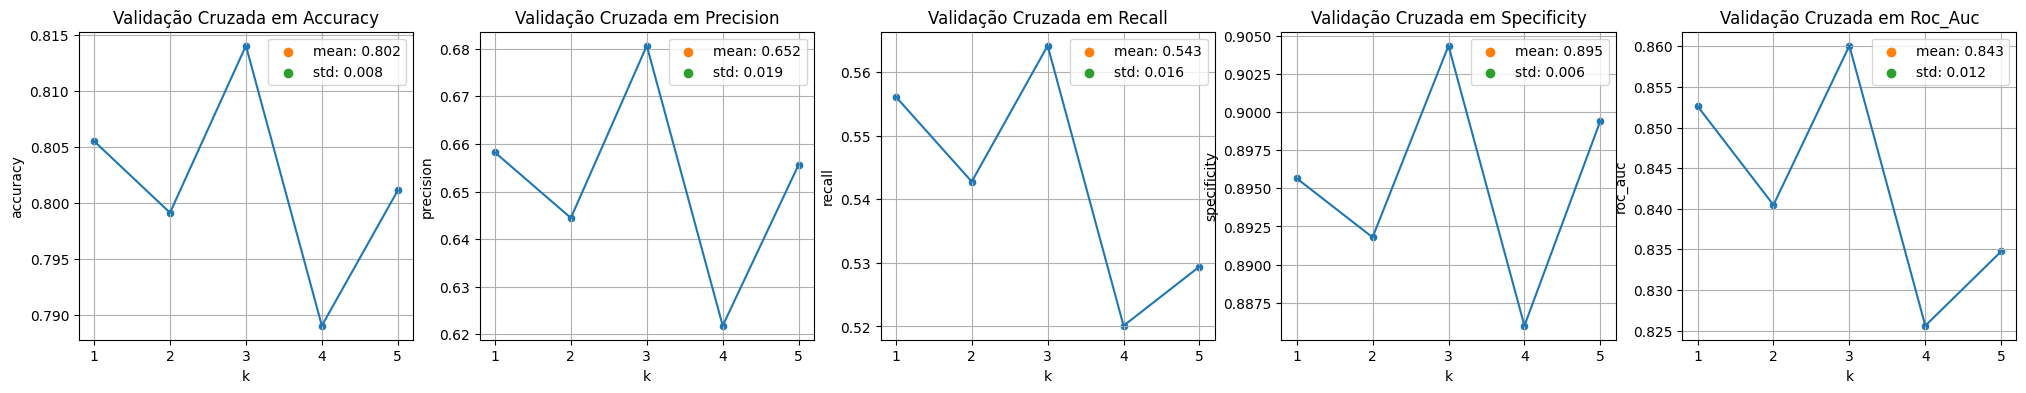

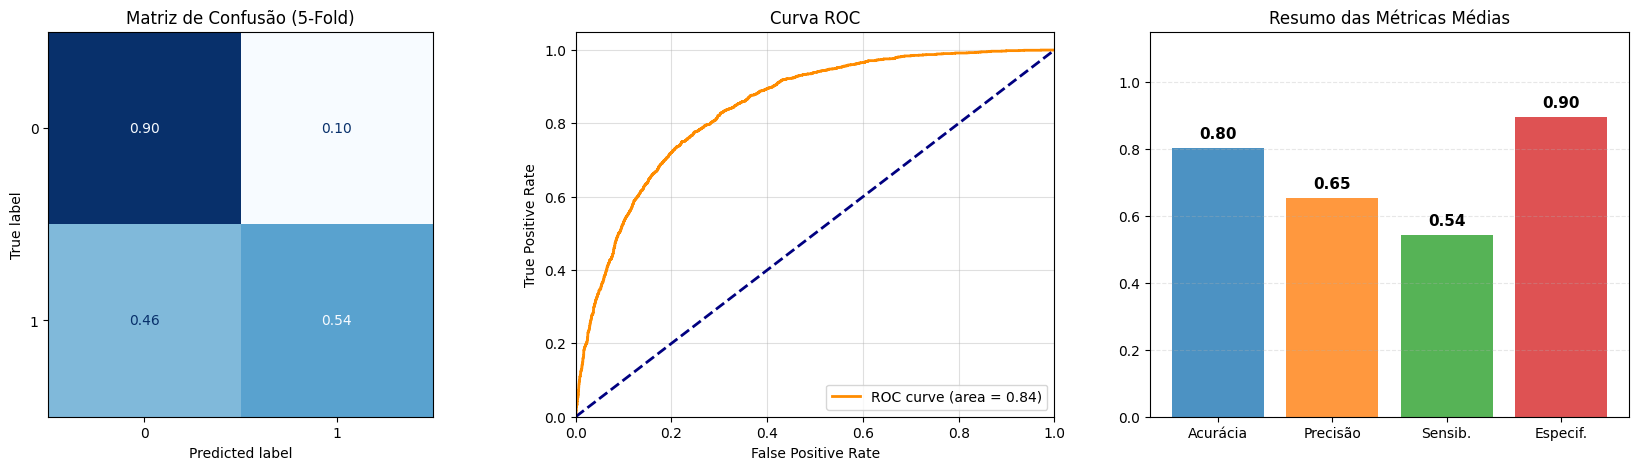

,name,values,mean,std,min,max,k0,k1,k2,k3,k4
0,accuracy,"[0.8055358410220014, 0.7991483321504613, 0.814...",0.801787,0.008171,0.789062,0.814053,0.805536,0.799148,0.814053,0.789062,0.801136
1,precision,"[0.6582278481012658, 0.6444444444444445, 0.680...",0.652148,0.019193,0.621795,0.680645,0.658228,0.644444,0.680645,0.621795,0.655629
2,recall,"[0.5561497326203209, 0.5427807486631016, 0.564...",0.542524,0.016302,0.520107,0.564171,0.556150,0.542781,0.564171,0.520107,0.529412
3,specificity,"[0.8956521739130435, 0.8917874396135266, 0.904...",0.895440,0.006291,0.885990,0.904348,0.895652,0.891787,0.904348,0.885990,0.899420
4,roc_auc,"[0.852635046113307, 0.8404712082461443, 0.8600...",0.842707,0.012339,0.825599,0.860079,0.852635,0.840471,0.860079,0.825599,0.834753


ACCURACY: 80.18% (±0.82%)
PRECISION: 65.21% (±1.92%)
RECALL: 54.25% (±1.63%)
SPECIFICITY: 89.54% (±0.63%)
ROC_AUC: 84.27% (±1.23%)


In [7]:
class CrossValidation:
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall':  'recall',
        'specificity': make_scorer(recall_score, pos_label=0),
        'roc_auc': 'roc_auc'
    }
    
    def __init__(self, model, xData, yData, k=4, seed=42):
        self.selected = str(model.__class__.__name__)
        self.model = clone(model)
        self.xData = xData
        self.yData = yData
        self.scores = {}
        self.seed   = seed
        self.k = k

    def update(self):
        self.cv_splitter = StratifiedKFold(n_splits=self.k, shuffle=True, random_state=self.seed)

        result = cross_validate(**{
            'estimator': self.model,
            'X':  self.xData,
            'y':  self.yData,
            'cv': self.cv_splitter,
            'scoring': self.scoring,
            'return_train_score': False
        })
        self.scores = [self.process(result, metric) for metric in self.scoring.keys()]
        self.accuracy    = np.mean(self.scores[0]['values'])
        self.precision   = np.mean(self.scores[1]['values'])
        self.recall      = np.mean(self.scores[2]['values'])
        self.specificity = np.mean(self.scores[3]['values'])
        self.auc         = np.mean(self.scores[4]['values'])

        data = []
        for metric in self.scores:           
            for i, value in enumerate(metric.get('values')):
                metric[f'k{i}'] = value
            data.append(metric)
        self.df = pd.DataFrame(data)
        

    def process(self, result, key):
        values = result[f'test_{key}']

        return {
            'name': key,
            'values': values,
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }
    
    def info(self):
        return {
            'model': self.selected,
            'accuracy': self.accuracy,
            'precision': self.precision,
            'recall': self.recall,
            'specificity': self.specificity,
            'auc': self.auc,
        }

    def print(self):
        display(self.df)
        
        for metric in self.scores:
            name = metric.get('name').upper()
            mean = metric.get('mean')*100
            std  = metric.get('std')
            print(f'{name}: {mean:.2f}% (±{std*100:.2f}%)')

    def plot(self):
        plt.figure(figsize=(25, 4))
        for i, row in self.df.iterrows():
            metric, values = row['name'], row['values']
            kData = [j+1 for j in range(self.k)]

            plt.subplot(1, len(self.df), i+1)
            plt.plot(kData, values)
            plt.scatter(kData, values, s=20)
            for info in ['mean', 'std']:
                plt.scatter([], [], label=f'{info}: {row[info]:.3f}')
            plt.xticks(kData); plt.title(f'Validação Cruzada em {metric.title()}')
            plt.grid(); plt.xlabel('k'); plt.ylabel(metric); plt.legend()
        plt.show()

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5)) 
        y_pred = cross_val_predict(self.model, self.xData, self.yData, cv=self.cv_splitter)
        cm     = confusion_matrix(self.yData, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', values_format='.2f', ax=ax1, colorbar=False)
        ax1.set_title(f'Matriz de Confusão ({self.k}-Fold)')

        try:
            y_probas = cross_val_predict(self.model, self.xData, self.yData, cv=self.cv_splitter, method='predict_proba')
            y_scores = y_probas[:, 1] 
        except AttributeError:
            y_scores = cross_val_predict(self.model, self.xData, self.yData, cv=self.cv_splitter, method='decision_function')
        
        fpr, tpr, _ = roc_curve(self.yData, y_scores)
        roc_auc     = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlim([0.0, 1.0]); ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate'); ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Curva ROC'); ax2.legend(loc="lower right"); ax2.grid(alpha=0.4)
        
        metrics_labels = ['Acurácia', 'Precisão', 'Sensib.', 'Especif.']
        metrics_values = [self.accuracy, self.precision, self.recall, self.specificity]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        bars   = ax3.bar(metrics_labels, metrics_values, color=colors, alpha=0.8)
        ax3.set_ylim(0, 1.15); ax3.set_title('Resumo das Métricas Médias')
        ax3.grid(axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height()+.02, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        plt.show()


cross = CrossValidation(model, xData, yData, k=K_CV)
cross.update()
cross.plot()
cross.print()

# AVALIAÇÃO GAUSSIANA
O valor mais provável em uma distribuição gaussiana é a média, com a relação

$$\mu \pm t\cdot\frac{\sigma_a}{\sqrt{n}}$$

- $\sigma_a$ é o desvio padrão amostral, considerando $n-1$ graus de liberade (ddof no numpy)
- $\mu$ é a média
- $t$ é o t_student para corrigir a amostra com $n$-1 e aqui vamos adotar a tabela para 95% de confiança (os dados vão cair em um intervalo $\pm$ ... com 95% de confiança) 

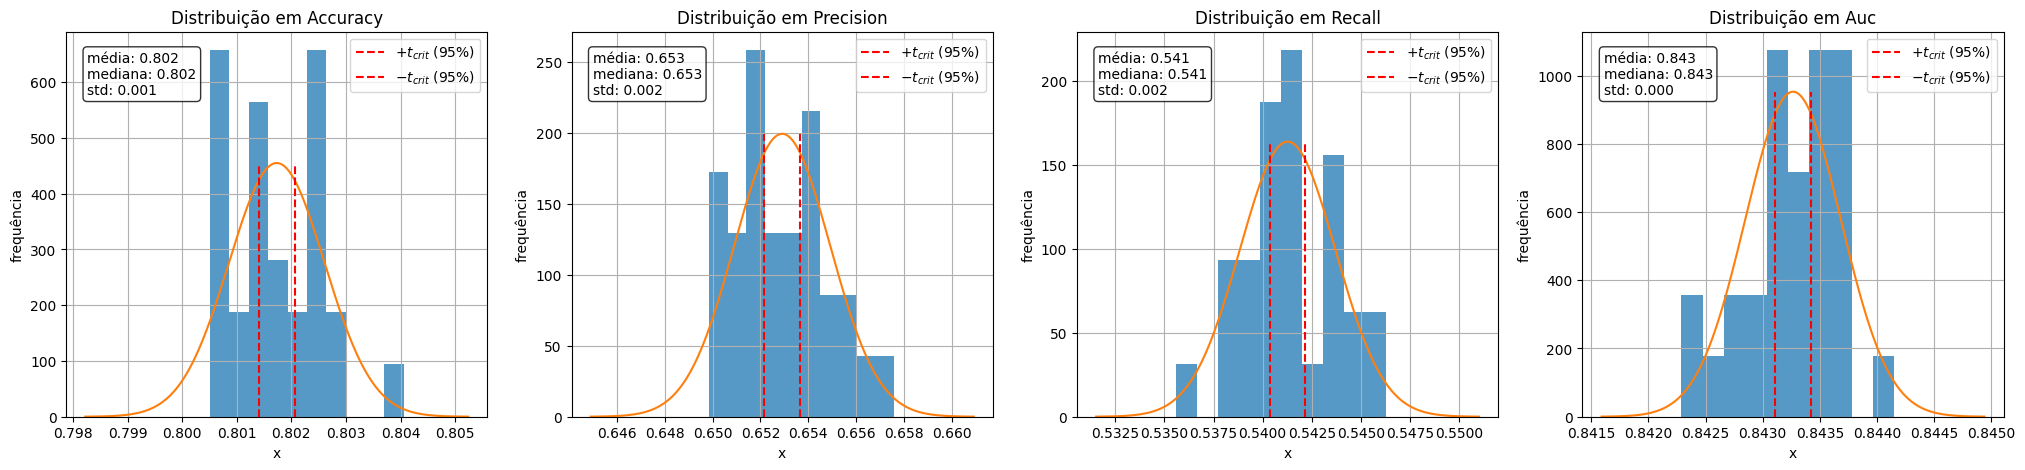

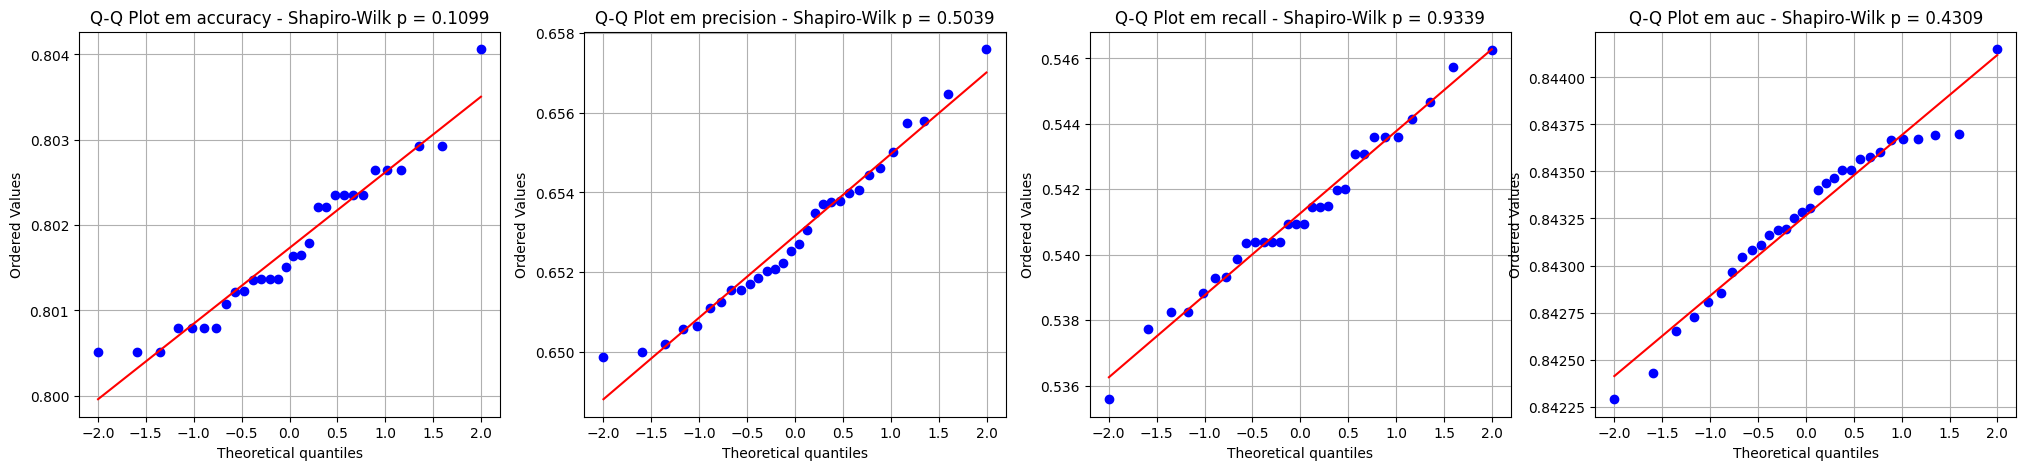

{'accuracy': 0.8017320673914446,
 'precision': 0.6529081796802337,
 'recall': 0.5412685122793939,
 'specificity': 0.8958193218026705,
 'auc': 0.8432654935999171}

In [8]:
class GaussianAnalyser:
    student = {
        1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306,9: 2.262, 10: 2.228, 11: 2.201,
        12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110, 18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080,
        22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060, 26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042, 40: 2.021,
        60: 2.000, 80: 1.990, 100: 1.984, 120: 1.980, "infty": 1.960
    }

    metric_labels = ['accuracy','precision', 'recall', 'specificity', 'auc']

    def __init__(self, trainer, n=30):
        self.trainer = trainer
        self.n = n

    def update(self):
        self.metrics      = {metric: [] for metric in self.metric_labels}
        self.trainer.seed = None

        for i in range(self.n):
            self.trainer.update()
            info = self.trainer.info()
            
            for name in self.metric_labels:
                self.metrics[name].append(info[name])

    def info(self):
        response = {}

        for metric, values in self.metrics.items():
            response[metric] = float(np.mean(values))

        return response

    def gaussian(self, metric):
        data  = np.array(self.metrics[metric])
        mu    = data.mean()
        sigma = data.std(ddof=1)

        x  = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)
        y  = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu)/sigma)**2)
        dx = (x[1] - x[0])
        p  = (y * dx)

        t = self.student[self.n-1] if self.n < 120 else self.student["infty"]
        x_crit = t * sigma / np.sqrt(self.n)

        plt.title(f'Distribuição em {metric.title()}')
        plt.hist(data, density=True, alpha=0.75)
        plt.plot(x, y)
        plt.plot([(mu - x_crit) for i in x], np.linspace(0, max(y), len(x)), '--', color='red', label='$+t_{crit}$ (95%)')
        plt.plot([(mu + x_crit) for i in x], np.linspace(0, max(y), len(x)), '--', color='red', label='$-t_{crit}$ (95%)')
        
        text = f'média: {mu:.3f}\nmediana: {np.median(data):.3f}\nstd: {np.std(data):.3f}'
        opts = dict(boxstyle='round', facecolor='white', alpha=0.8)
        
        plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=opts)
        plt.xlabel('x'); plt.ylabel('frequência'); plt.grid(); plt.legend()

    def qqplot(self, key):
        data = np.array(self.metrics[key])
        stats.probplot(data, dist="norm", plot=plt)
        stat, p = stats.shapiro(data)
        plt.title(f"Q-Q Plot em {key} - Shapiro-Wilk p = {p:.4f}")
        plt.grid()

    def plot(self):
        plt.figure(figsize=(25, 5))
        plt.subplot(1, 4, 1); self.gaussian('accuracy')
        plt.subplot(1, 4, 2); self.gaussian('precision')
        plt.subplot(1, 4, 3); self.gaussian('recall')
        plt.subplot(1, 4, 4); self.gaussian('auc')
        plt.show()

        plt.figure(figsize=(25, 5))
        plt.subplot(1, 4, 1); self.qqplot('accuracy')
        plt.subplot(1, 4, 2); self.qqplot('precision')
        plt.subplot(1, 4, 3); self.qqplot('recall')
        plt.subplot(1, 4, 4); self.qqplot('auc')
        plt.show()


cross    = CrossValidation(model, xData, yData, K_CV)
analyser = GaussianAnalyser(cross)
analyser.update()
analyser.plot()
analyser.info()

# GRID SEARCH

In [9]:
cv_splitter = StratifiedKFold(n_splits=K_CV, shuffle=True, random_state=42)
grid = GridSearchCV(model, params, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
grid.fit(xData, yData)

print('Best Params: ', grid.best_params_)
print('Best AUC:    ', grid.best_score_)

Best Params:  {'model__C': 10, 'model__max_iter': 2000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best AUC:     0.8428155336178582


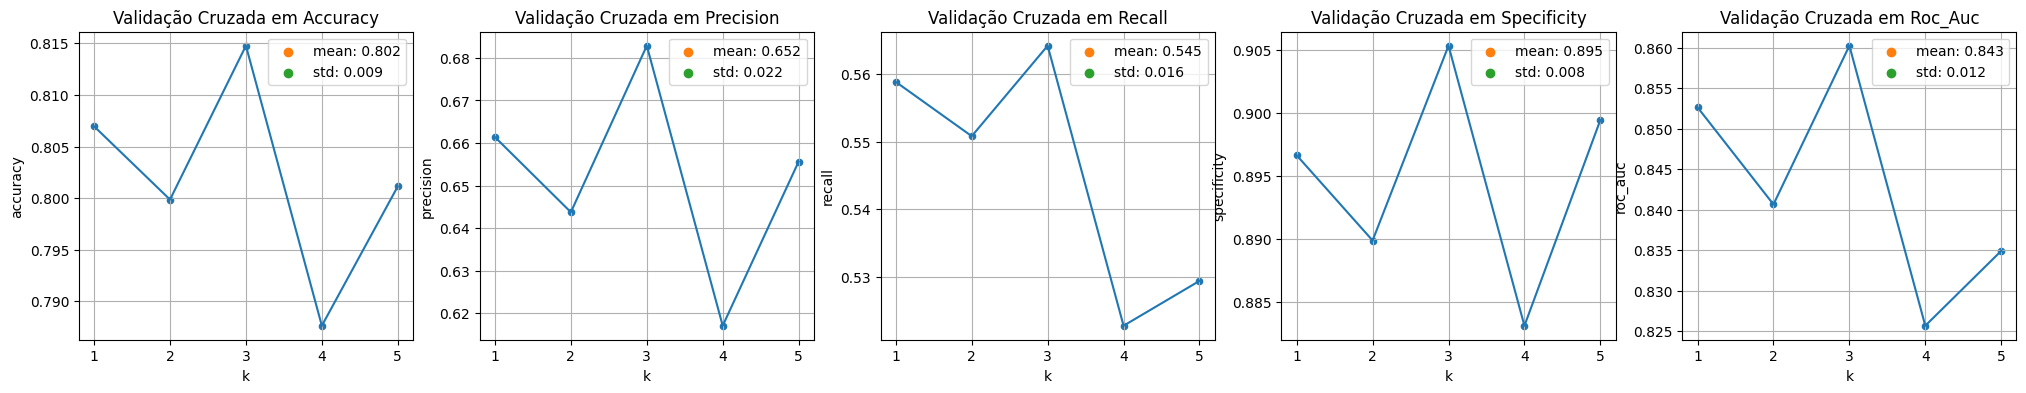

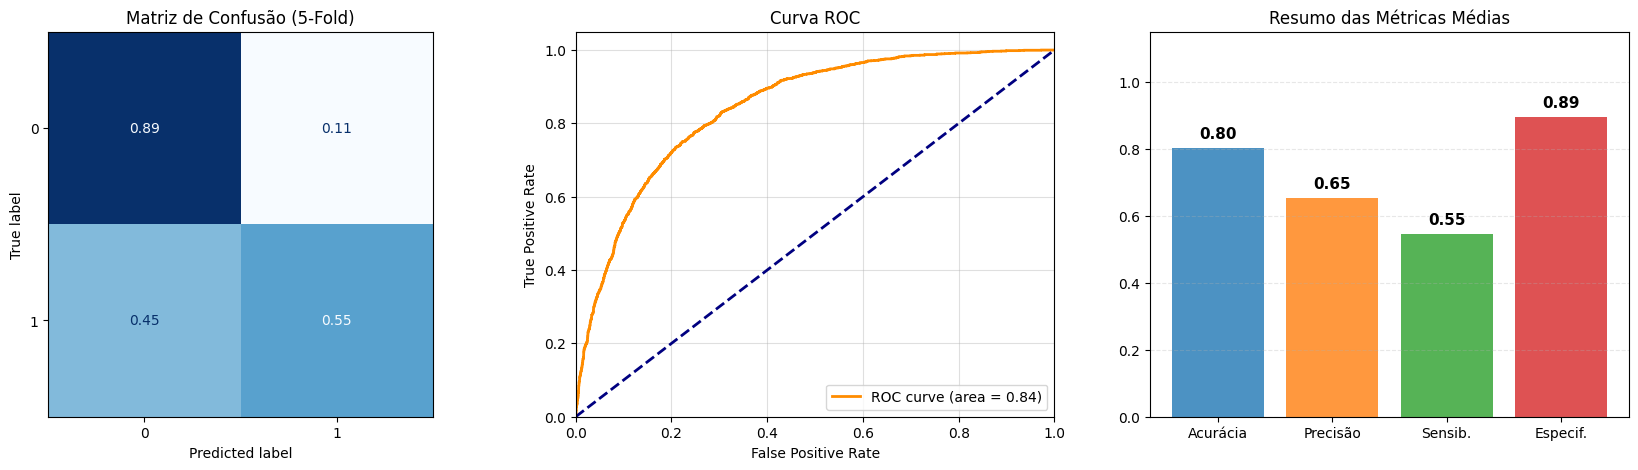

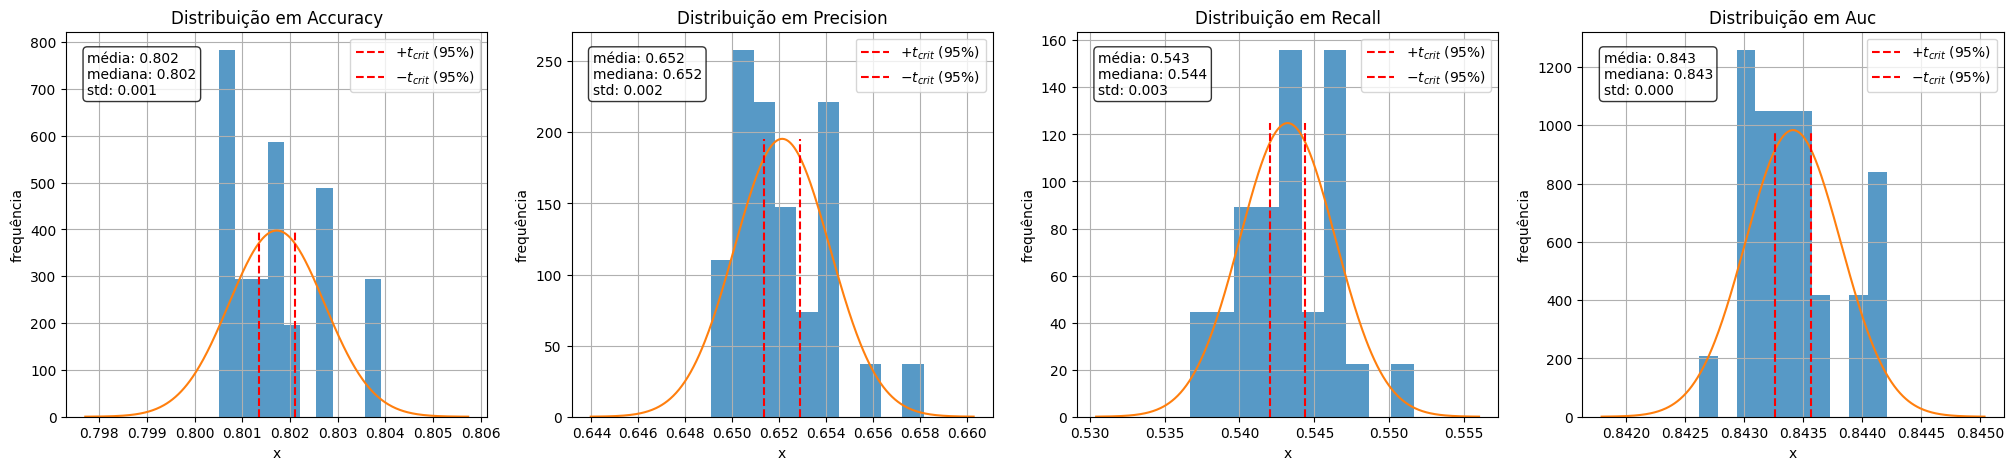

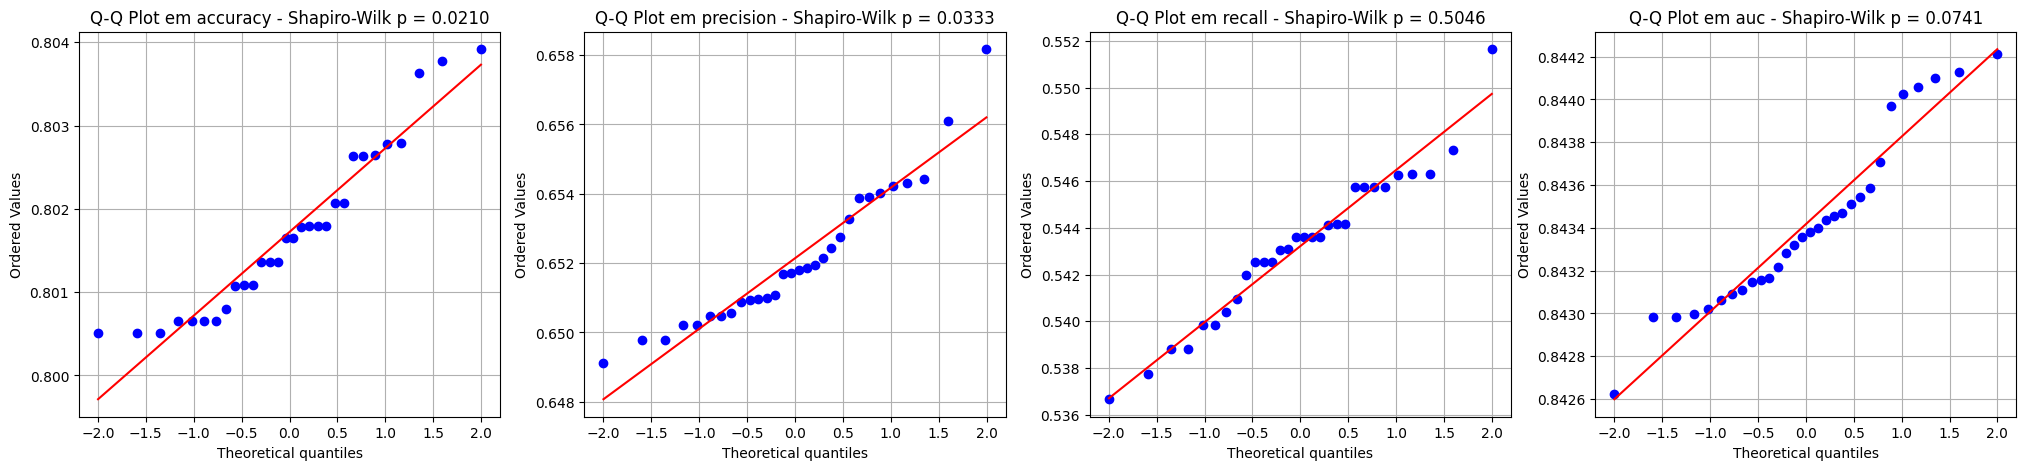

{'accuracy': 0.8017227522743402,
 'precision': 0.6521378449376981,
 'recall': 0.5432168236536634,
 'specificity': 0.8951042649747551,
 'auc': 0.8434168390191352}

In [10]:
cross    = CrossValidation(grid.best_estimator_, xData, yData, K_CV)
analyser = GaussianAnalyser(cross)

cross.update()
cross.plot()

analyser.update()
analyser.plot()

analyser.info()

# VERIFICAÇÃO DE VARIÁVEIS

In [11]:
class VariableRemover:
    def __init__(self, model, xData, yData, k=5):
        self.model = clone(model)
        self.xData = xData
        self.yData = yData
        self.k  = k
        self.history = []

        analyser = GaussianAnalyser(CrossValidation(model, xData, yData, k=self.k))
        analyser.update()
        self.baseAUC = float(analyser.info().get('auc'))
        print(f"Base AUC: {self.baseAUC:.5f}")

    def getAUC(self, X, Y):
        analyser = GaussianAnalyser(CrossValidation(self.model, X, Y, k=self.k))
        analyser.update()
        return analyser.info().get('auc')

    def update(self):       
        variables    = self.xData.columns.tolist()
        self.history = []

        for variable in variables:
            X      = self.xData.drop(columns=[variable])
            newAUC = self.getAUC(X, self.yData)
            delta  = (newAUC - self.baseAUC)*100
            
            self.history.append({
                'removed': variable, 
                'auc':   round(newAUC, 5), 
                'delta': round(abs(delta), 5)
            })


remover = VariableRemover(grid.best_estimator_, xData, yData, K_CV)
remover.update()
pd.DataFrame(remover.history)

Base AUC: 0.84324


,removed,auc,delta
0,tenure,0.83578,0.74553
1,InternetService_Fiber optic,0.84230,0.09326
2,Contract_Two year,0.83790,0.53316
3,PaymentMethod_Electronic check,0.84147,0.17665
4,InternetService_No,0.84069,0.25405
5,TotalCharges,0.84103,0.22081
6,MonthlyCharges,0.84351,0.02731
7,PaperlessBilling,0.84185,0.13879
8,Contract_One year,0.84045,0.27862
9,OnlineSecurity,0.84151,0.17251


# TREINANDO MODELO FINAL

In [13]:
model = clone(grid.best_estimator_)

model.fit(xData, yData)
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model',
   LogisticRegression(C=10, max_iter=2000, penalty='l1', solver='liblinear'))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'model': LogisticRegression(C=10, max_iter=2000, penalty='l1', solver='liblinear'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 10,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 2000,
 'model__multi_class': 'deprecated',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'liblinear',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [14]:
df['prediction'] = model.predict(xData)
print(f'acertos: {100*(df.prediction == df.Churn).sum()/len(df):.2f}%')

acertos: 80.41%


In [18]:
data = {
    'model': model,
    'params': model.get_params(),
    'K_CV': K_CV,
    'results': analyser.info()
}

pd.DataFrame([data['results']])

,accuracy,precision,recall,specificity,auc
0,0.801723,0.652138,0.543217,0.895104,0.843417
